# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1HMK2wftd1PK1p4z63uMg_DEeodGuXFj6/view?usp=sharing


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [0]:
line1 = ""
line2 = ""

for line in open('/content/drive/My Drive/APS360/Labs/Lab5/SMSSpamCollection'):
    if line1 == "" and line[0:3]=="ham":
      line1 = line
    if line2 == "" and line[0:4]=="spam":
      line2 = line


print("spam:  "+line2)
print("non-spam:  "+line1)


spam:  spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

non-spam:  ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



**Answer:**

"spam" and "ham"


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [0]:
spam_num = 0;
ham_num = 0;
num = 0
for line in open('/content/drive/My Drive/APS360/Labs/Lab5/SMSSpamCollection'):
    num += 1
    if(line[0:3] == "ham"):
      ham_num += 1
    else:
      spam_num += 1
print(ham_num)
print(spam_num)


4827
747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Answer:**

Advantage: 
1. Character-based models can make sure that the discrete space is smaller compared with word-based because there are only about 97 English-language characters in common usage if we include all punctuation marks. 

2. Character-based models enable us to mimic grammatically correct sequences for a wide range of languages.

Disadvantage:
1. Charater-based models usually have a lower accuracy than word-level models because it need to predict more output compared with word-based model.

2. Charater-based models usually have a higher computation cost than word-level models because char-based RNN require much bigger hidden layer to successfully model long-term dependencies, which means higher computational costs.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [0]:
import torchtext
import random

text_field = torchtext.data.Field(sequential=True,      # text sequence
                  tokenize=lambda x: x, # because are building a character-RNN
                  include_lengths=True, # to track the length of sequences, for batching
                  batch_first=True,
                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                  use_vocab=False,     # don't need to track vocabulary
                  is_target=True,      
                  batch_first=True,
                  preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/APS360/Labs/Lab5/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...

print(dataset[0].sms)
print(dataset[0].label)
train, valid, test = dataset.split(split_ratio = [0.6, 0.2, 0.2])

print("Train dataset size is {}".format(len(train)))
print("Valid dataset size is {}".format(len(valid)))
print("Test dataset size is {}".format(len(test)))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0
Train dataset size is 3343
Valid dataset size is 1115
Test dataset size is 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [0]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

**Answer:**

Because if there are more non-spam data than spam data in our training data, then our model will tend to identify output as non-spam. So we need to have a balanced training set to train our mdoel to treat spam and non-spam SMS data fairly and to improve our accuracy.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [0]:
text_field.build_vocab(train)
print(type(text_field.vocab.stoi))
print(type(text_field.vocab.itos))

<class 'collections.defaultdict'>
<class 'list'>


**Answer:** 

text_field.vocab.stoi: a dictionary container mapping token strings to. numerical identifier

text_field.vocab.itos:  A list of token strings indexed by their numerical identifiers.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer:**

unk means "unknown", which represents some out of vocubulary character.

pad means "padding", which represents a string token used as padding.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train,
                      batch_size=32,
                      sort_key=lambda x: len(x.sms), # to minimize padding
                      sort_within_batch=True,  # sort within each batch
                      repeat=False)      # repeat the iterator for many epochs

valid_iter = torchtext.data.BucketIterator(valid,
                      batch_size=32,
                      sort_key=lambda x: len(x.sms), # to minimize padding
                      sort_within_batch=True,     # sort within each batch
                      repeat=False)   # repeat the iterator for many epochs
test_iter = torchtext.data.BucketIterator(test,
                      batch_size=32,
                      sort_key=lambda x: len(x.sms), # to minimize padding
                      sort_within_batch=True,  # sort within each batch
                      repeat=False)

In [0]:
n = 0
# for batch in train_iter:
#     print(len(batch))
#     print(batch.sms)
#     print(batch.label)
#     n += 1
#     if n==10:
#       break

n = 0
for batch in train_iter:
    n+=1
    num = 0
    for t in batch.sms[0]:
      a = t.tolist()
      num += a.count(1)
    print("The number of pad in batch {} is {}".format(n, num))
    print("The maximum length of input sequence in batch {} is {}\n".format(n, batch.sms[1].max()))
    if(n==10):
      break


The number of pad in batch 1 is 0
The maximum length of input sequence in batch 1 is 158

The number of pad in batch 2 is 61
The maximum length of input sequence in batch 2 is 84

The number of pad in batch 3 is 26
The maximum length of input sequence in batch 3 is 43

The number of pad in batch 4 is 0
The maximum length of input sequence in batch 4 is 160

The number of pad in batch 5 is 18
The maximum length of input sequence in batch 5 is 146

The number of pad in batch 6 is 21
The maximum length of input sequence in batch 6 is 151

The number of pad in batch 7 is 37
The maximum length of input sequence in batch 7 is 45

The number of pad in batch 8 is 9
The maximum length of input sequence in batch 8 is 145

The number of pad in batch 9 is 29
The maximum length of input sequence in batch 9 is 162

The number of pad in batch 10 is 51
The maximum length of input sequence in batch 10 is 56



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [0]:
one_hot_size = len(text_field.vocab.itos)
identity = torch.eye(one_hot_size)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x= self.one_hot_emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x.float(), h0.float())
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

    def one_hot_emb(self, data_iter):
          data_iter = data_iter.unsqueeze(2).expand(data_iter.shape[0],data_iter.shape[1],one_hot_size)
          ret = data_iter.clone()
          for i, v1 in enumerate(data_iter):
            for j, v2 in enumerate(v1):
              ret[i][j]=identity[v2[0].numpy()]
          return ret.long()
print(one_hot_size)

111


In [0]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
# print(ident[0]) # one-hot vector
# print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
criterion = nn.CrossEntropyLoss()
def get_accuracy(model, data_iter):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
 
    correct, total = 0, 0
    for sms, label in data_iter:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += label.shape[0]
    loss = criterion(output, label)
    return correct / total, float(loss)



### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

The final train accuracy is 0.7444861950661656
The final valid accuracy is 0.7569506726457399


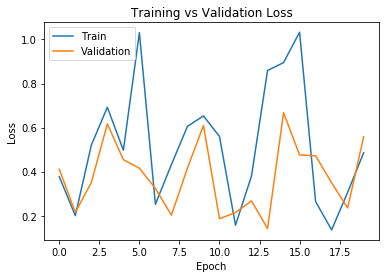

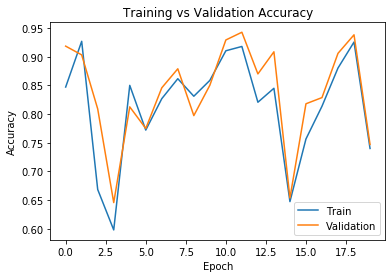

In [0]:
import matplotlib.pyplot as plt
def train_RNN_and_plot(model, train_iter, valid_iter, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, train_acc, valid_acc, valid_los, epochs = [], [], [], [], []
    for epoch in range(num_epochs):
        for sms, labels in train_iter:
          
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        train_losses.append(float(loss))

        epochs.append(epoch)
        train_accuracy, train_loss = get_accuracy(model, train_iter)
        train_acc.append(train_accuracy)

        valid_accuracy, valid_loss = get_accuracy(model, valid_iter)
        valid_los.append(valid_loss)
        valid_acc.append(valid_accuracy)

    final_train_accuracy, final_train_loss = get_accuracy(model, train_iter)
    final_valid_accuracy, final_valid_loss = get_accuracy(model, valid_iter)
    print("The final train accuracy is {}".format(final_train_accuracy))
    print("The final valid accuracy is {}".format(final_valid_accuracy))

    # plotting
    plt.title("Training vs Validation Loss")
    plt.plot(train_losses, label="Train")
    plt.plot(valid_los, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
model0 = RNN(one_hot_size, one_hot_size, 2)
train_RNN_and_plot(model0, train_iter, valid_iter, num_epochs=20, learning_rate=1e-3)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [0]:
import time
def train_RNN(model, train_iter, valid_iter, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(num_epochs):
        for sms, labels in train_iter:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
    end_time1 = time.time()
    print("Training takes about: {} seconds".format(end_time1-start_time))

    final_train_accuracy, final_train_loss = get_accuracy(model, train_iter)
    final_valid_accuracy, final_valid_loss = get_accuracy(model, valid_iter)

    end_time2 = time.time()
    print("Calculating accuracy takes about: {} seconds".format(end_time2-end_time1))
    print("The final train accuracy is {}".format(final_train_accuracy))
    print("The final valid accuracy is {}".format(final_valid_accuracy))


**Answer:**

The 4 hyperparameters that I choose to tune are: **learning_rate, num_epochs, batch_size, size of RNN hidden state.** Because we don't need to include our training curve here, I remove the plot part in my previous training code and rewrite a new training code as shown above. 

1st set of hyperparameters: **learning_rate = 1e-5, num_epochs = 1, batch_size = 32, size of RNN hidden state = input size = 108**

**Reasoning:** At first, I would like to choose a small learning_rate and only 1 times of epoch to view how my model perform under a initial condition and  start tuning my hyperparameters based on that.

In [0]:
model1 = RNN(one_hot_size, one_hot_size, 2)
train_RNN(model1, train_iter, valid_iter, num_epochs=1, learning_rate=1e-5)

Training takes about: 11.302847385406494 seconds
Calculating accuracy takes about: 10.723683834075928 seconds
The final train accuracy is 0.5061322165719414
The final valid accuracy is 0.442152466367713


2nd set of hyperparameters: **learning_rate = 1e-4, num_epochs = 5, batch_size = 32, size of RNN hidden state = input size = 108**

**Reasoning:** Based on the accuracy above, I found that the accuracy is too low. I think the problem is that my learning rate and epoch number are too small, which leads the model to get stuck in a local minimum and stop learning further. So I decided to increase the learning_rate and number of epochs to see if it the accuracy can increase

In [0]:
model2 = RNN(one_hot_size, one_hot_size, 2)
train_RNN(model2, train_iter, valid_iter, num_epochs=5, learning_rate=1e-4)

Training takes about: 50.72365856170654 seconds
Calculating accuracy takes about: 10.993427515029907 seconds
The final train accuracy is 0.867185163027221
The final valid accuracy is 0.8690582959641255


3rd set of hyperparameters: **learning_rate = 1e-4, num_epochs = 5, batch_size = 64, size of RNN hidden state = 100**

**Reasoning**: The training&validation accuracy of model2 increase a lot compared with the model1. Since I increase the learning rate before, I would like to see if the batch_size need to be increased as well to match the learning rate. Based on my previous lab experience, there should be a direct relationship between learning rate and batch_size. So I decided to increase the batch size and change the hidden size to see if it can help the model learn better.

In [0]:
train_iter3 = torchtext.data.BucketIterator(train,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

valid_iter3 = torchtext.data.BucketIterator(valid,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_iter3 = torchtext.data.BucketIterator(test,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)

model3 = RNN(one_hot_size, 100, 2)
train_RNN(model3, train_iter3, valid_iter3, num_epochs=5, learning_rate=1e-4)

Training takes about: 45.96046710014343 seconds
Calculating accuracy takes about: 10.373132228851318 seconds
The final train accuracy is 0.867185163027221
The final valid accuracy is 0.8690582959641255


4rd set of hyperparameters: **learning_rate = 1e-4, num_epochs = 10, batch_size = 32, size of RNN hidden state = input_size = 108**

In [0]:
model4 = RNN(one_hot_size, one_hot_size, 2)
train_RNN(model4, train_iter, valid_iter, num_epochs=10, learning_rate=1e-4)

Training takes about: 99.40343022346497 seconds
Calculating accuracy takes about: 10.793292999267578 seconds
The final train accuracy is 0.9602153754113072
The final valid accuracy is 0.95695067264574


**Reasoning:** Compared with model2, model3 doesn't has improvement in accuracy. I think the reason is that maybe the ogrinal batch_size = 32 is a good fit for the learning rate. So I change the batch_size back to 32 and increase the num_epochs to 10. 

**Best Validation Accuracy:**  **95.7%**(model 4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [0]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)# TODO

valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                     batch_size=32,
                     sort_key=lambda x: len(x.sms), # to minimize padding
                     sort_within_batch=True,        # sort within each batch
                    repeat=False)
valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                     batch_size=32,
                     sort_key=lambda x: len(x.sms), # to minimize padding
                     sort_within_batch=True,        # sort within each batch
                    repeat=False)  

nospam_valid_accuracy = get_accuracy(model4,valid_nospam_iter)[0]
false_positive_rate = 1- nospam_valid_accuracy

spam_valid_accuracy = get_accuracy(model4,valid_spam_iter)[0]
false_negative_rate = 1-spam_valid_accuracy

print("False positive rate of validation set is: {}".format(false_positive_rate))
print("False negative rate of validation set is: {}".format(false_negative_rate))

False positive rate of validation set is: 0.00515995872033026
False negative rate of validation set is: 0.28767123287671237


**Answer:**

False positive rate of validation set is **0.5%**, False negative rate of validation set is **28.8%**

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer:**

***The impact of false positive:***

The user may treat the real useful message as a spam message and ignore it, so the user may miss some important mesasges.

**The impact of false negative:**

This user may treat spam message as real message and and fall into some spams, losing money or even get into danger.


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [0]:
test_accuracy = get_accuracy(model4, test_iter)[0]
print("Final test accuracy is: {}".format(test_accuracy))

Final test accuracy is: 0.9605026929982047


**Answer:**

The final test accuracy of my best model is: **96.05%**

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [0]:

test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)

test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)# TODO

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                     batch_size=32,
                     sort_key=lambda x: len(x.sms), # to minimize padding
                     sort_within_batch=True,        # sort within each batch
                    repeat=False)
test_spam_iter = torchtext.data.BucketIterator(test_spam,
                     batch_size=32,
                     sort_key=lambda x: len(x.sms), # to minimize padding
                     sort_within_batch=True,        # sort within each batch
                    repeat=False)  

nospam_test_accuracy = get_accuracy(model4,test_nospam_iter)[0]
test_false_positive_rate = 1- nospam_test_accuracy

spam_test_accuracy = get_accuracy(model4,test_spam_iter)[0]
test_false_negative_rate = 1-spam_test_accuracy

print("False positive rate of test set is: {}".format(test_false_positive_rate))
print("False negative rate of test set is: {}".format(test_false_negative_rate))

False positive rate of test set is: 0.005224660397074143
False negative rate of test set is: 0.24840764331210186


**Answer:**

False positive rate of test set is **0.5%**, False negative rate of test set is **24.8%**

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [0]:
msg = "machine learning is sooo cool!"
msg_list=[]
for char in msg:
  msg_list.append(text_field.vocab.stoi[char])

t = torch.FloatTensor(msg_list)
out = torch.sigmoid(model4(t.unsqueeze(0)))
# pred = out.max(1, keepdim=True)[1]
print(out)

tensor([[0.8392, 0.1586]], grad_fn=<SigmoidBackward>)


**Answer:**

The probability that "machine learning is sooo cool!" is spam is **15.86%** 

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer:**

My base model use the proportion of spam messages in a relatively large dataset as the probability of any new message being a spam messgae. For example, for the dataset in this lab with size = 5574. The proportion of a spam message = 747/(747+4827) = 0.134 and my model will just assume that any new input has a possibility of 0.134 to be a spam-message. So my base model can use the random() function to generate a random number between (0, 1) for every new input and if that value is smaller than 0.134, then my base model will just predict this input message as a spam message and otherwise it's a non-spam message.
